# **Notebook 5: Modeling & Evaluation**

## Objectives

* Fit and evaluate a regression model to predict prices on houses.

## Inputs

* outputs/datasets/collection/house_prices_records.csv
* Instructions on which features to use for data cleaning and feature engineering can be found in respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/housing'

# Step 1: Load data

Here we load the dataset and separate the target variable ('y') from the predictor variables ('X').



In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv"))

# Separate predictors and target
X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

print(X.shape)
X.head(3)

(1460, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,8450,65.0,196.0,61,5,7,856,0.0,2003,2003
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,9600,80.0,0.0,0,8,6,1262,NaN,1976,1976
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,11250,68.0,162.0,42,5,7,920,NaN,2001,2002


---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [78]:
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.selection import DropFeatures
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertToInt64(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            X[col] = X[col].astype('Int64')
        return X

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        
        ("ConvertToInt64", ConvertToInt64(columns=['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'])),
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        
        ("MedianImputer", MeanMedianImputer(imputation_method='median', 
                                             variables=['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'])),
        
        ("CategoricalImputer", CategoricalImputer(variables=['BsmtFinType1', 'GarageFinish'])),
        
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['1stFlrSF', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage'])),
        
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()



Pipeline(steps=[('ConvertToInt64',
                 ConvertToInt64(columns=['2ndFlrSF', 'BedroomAbvGr',
                                         'GarageYrBlt', 'LotFrontage',
                                         'MasVnrArea'])),
                ('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('MedianImputer',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('CategoricalImputer',
                 Categ...
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransforme

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineReg(self.models[key])  # changed this to regression
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1168, 23) (1168,) (292, 23) (292,)


## Extra step

In the cell below, we are manually converting selected numerical columns to integer type after splitting the data, because that conversion step is not included in our pipeline (see notebook 1 for details). This step is separate from the data cleaning and transformation steps that will be applied during the pipeline fitting process.

We also do conversions from float to int type in the dataset inherited_df. However, the type conversions for inherited_df will be done separately because they are different from the ones used for records_df.

In [ ]:
# First we load inherited_df dataset
inherited_df = pd.read_csv("outputs/datasets/future_data/inherited_houses.csv")

# Then we drop columns 'EnclosedPorch' and 'WoodDeckSF' just like the main data
inherited_df = inherited_df.drop(['EnclosedPorch', 'WoodDeckSF'], axis=1)

# We perform data type conversion
cols_to_convert_inherited = ['BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'TotalBsmtSF']
for col in cols_to_convert_inherited:
    inherited_df[col] = inherited_df[col].astype('int64')

# Note that 'GarageYrBlt' is the only variable present in both lists 
# because it's the only one that needs to be converted to an integer in both dataframes.

Note: we do not handle target imbalance at this point since the target in this project is a continuous variable. It's possible to come back to this step later and add a cell to normalize the distribution of the target variable to fit the model better.

## Fit pipeline

In [9]:
# Fit the PipelineDataCleaningAndFeatureEngineering pipeline
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 17) (292, 17) (1168,) (292,)


## Grid Search CV - Sklearn

Use standard hyperparameters to find most suitable algorithm

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models_quick_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
    "LGBMRegressor": LGBMRegressor(random_state=0),
}

params_quick_search = {
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "AdaBoostRegressor": {},
    "XGBRegressor": {},
    "LGBMRegressor": {},
}


And then Quick GridSearch CV

In [11]:
from sklearn.metrics import make_scorer, mean_absolute_error

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring=scorer, n_jobs=-1, cv=5)



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for LGBMRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
1,GradientBoostingRegressor,-26017.738008,-23275.533492,-20882.497828,1798.470621
4,LGBMRegressor,-27324.763193,-23704.651367,-18903.899719,2944.679209
0,RandomForestRegressor,-30478.201242,-27885.798355,-24012.150233,2182.091385
2,AdaBoostRegressor,-33391.792249,-30494.340606,-26700.207193,2408.047289
3,XGBRegressor,-33345.455429,-31342.340933,-28968.361353,1794.742211


### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search
* NB: The reason LGBMRegressor is not included here despite having the second lowest mean score is as folllows. When looking at metrics, it appeared that the model performed well on the train set, as indicated by low values of MAE, MSE, and RMSE, and a high value of R^2. However, there was a noticeable drop in performance on the test set, as indicated by higher values of MAE, MSE, and RMSE, and a lower value of R^2. This suggests that the model may have been overfitting the training data and not generalizing well to unseen data. Therefore I have chosen two models with better fit here.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
    },
    "GradientBoostingRegressor": {
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 6],
        'model__n_estimators': [100, 200],
    },
}

Extensive GridSearch CV

In [15]:
from sklearn.metrics import mean_absolute_error, make_scorer

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring=scorer, n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Check results

Here we get a summary table showing the results from the GridSearchCV operation. It includes the mean_score, which we can use to compare the performance of different hyperparameters configurations. The one with the lowest mean_score would be the optimal choice.

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate
28,GradientBoostingRegressor,-26017.738008,-23275.533492,-20882.497828,1798.470621,3,NaN,NaN,100,0.1
29,GradientBoostingRegressor,-26852.828778,-23775.99235,-20596.025843,2104.092471,3,NaN,NaN,200,0.1
30,GradientBoostingRegressor,-28182.164941,-24166.60657,-20175.154466,2577.804268,6,NaN,NaN,100,0.1
27,GradientBoostingRegressor,-28585.881753,-24520.059771,-21992.98277,2426.728119,6,NaN,NaN,200,0.01
31,GradientBoostingRegressor,-28520.726696,-24726.534705,-20570.2817,2603.853188,6,NaN,NaN,200,0.1
25,GradientBoostingRegressor,-27843.57585,-25074.160339,-23071.018609,1901.753515,3,NaN,NaN,200,0.01
14,RandomForestRegressor,-29006.723573,-26346.450531,-23399.948546,1796.144194,6,2,5,100,NaN
12,RandomForestRegressor,-29088.293502,-26354.48555,-23442.636783,1808.170436,6,2,2,100,NaN
15,RandomForestRegressor,-28935.220332,-26359.011053,-23428.948502,1781.981483,6,2,5,200,NaN
13,RandomForestRegressor,-29007.396486,-26377.107055,-23497.358914,1782.525663,6,2,2,200,NaN


Get best model name programmatically

In [17]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model. This contain a dictionary of the optimal hyperparameters for the best model as determined by the GridSearchCV. It doesn't contain the model itself, but only the parameters that gave the best performance during the cross-validation grid search

In [18]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Get the complete pipeline of the best model, including all preprocessing steps and the estimator itself, with the parameters set to their optimal values:

In [19]:
pipeline_rgr = grid_search_pipelines[best_model].best_estimator_
pipeline_rgr

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model', GradientBoostingRegressor(random_state=0))])

## Assess feature importance

In [20]:
X_train.head(3)

,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt
618,0,3,0,48,0,72.117860,285.045723,0,0,9.874667,17.923317,452,108,5,9,495.850351,2007
870,0,2,1,0,1,51.451694,133.391173,1,1,9.241645,14.220455,0,0,5,5,280.785318,1962
92,0,2,1,713,2,21.751877,176.329005,0,1,10.022651,16.765758,0,0,7,5,276.257124,1921


* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


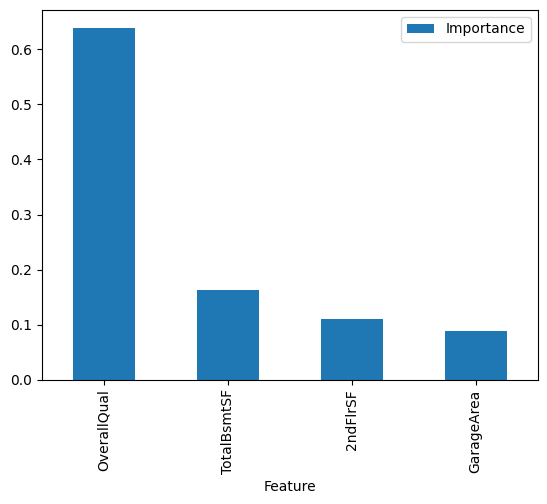

In [21]:
import matplotlib.pyplot as plt

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_rgr['feat_selection'].get_support()],
    'Importance': pipeline_rgr['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(X, y, pipeline):
    prediction = pipeline.predict(X)

    print('---  Regression Metrics  ---')
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y, prediction)}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y, prediction)}")
    print(f"Root Mean Squared Error (RMSE): {mean_squared_error(y, prediction, squared=False)}")
    print(f"R-squared (R^2): {r2_score(y, prediction)}")

def reg_performance(X_train, y_train, X_test, y_test, pipeline):
    print("#### Train Set #### \n")
    regression_metrics(X_train, y_train, pipeline)

    print("\n#### Test Set ####\n")
    regression_metrics(X_test, y_test, pipeline)


In [23]:
reg_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_rgr)

# The function reg_performance prints out the regression metrics 
# for our training and test datasets using the pipeline we trained.

#### Train Set #### 

---  Regression Metrics  ---
Mean Absolute Error (MAE): 17783.586852843655
Mean Squared Error (MSE): 580749250.1311158
Root Mean Squared Error (RMSE): 24098.739596317395
R-squared (R^2): 0.905675977685939

#### Test Set ####

---  Regression Metrics  ---
Mean Absolute Error (MAE): 22484.657630538044
Mean Squared Error (MSE): 1158042518.860478
Root Mean Squared Error (RMSE): 34030.023785775964
R-squared (R^2): 0.832309922037588


Overall, these results indicate that the model is performing well, with relatively low MAE values and high R-squared scores, indicating good accuracy and fit to the data.

# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().

## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [61]:
best_features

Index(['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea'], dtype='object')

New Pipeline for DataCleaning And FeatureEngineering

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertToInt64(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            X[col] = X[col].astype('Int64')
        return X

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("ConvertToInt64", ConvertToInt64(columns=['2ndFlrSF'])),        
        ("MedianImputer", MeanMedianImputer(imputation_method='median', 
                                             variables=['2ndFlrSF'])),
        ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['TotalBsmtSF', 'GarageArea'])),
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('ConvertToInt64', ConvertToInt64(columns=['2ndFlrSF'])),
                ('MedianImputer', MeanMedianImputer(variables=['2ndFlrSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF',
                                                  'GarageArea']))])

## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [63]:
def PipelineReg(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

## Split Train Test Set, considering only with best features


In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


We filter only the most important variables

In [65]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(1168, 4) (1168,) (292, 4) (292,)


,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
618,9,1822,0.0,774
870,5,894,0.0,308
92,5,876,0.0,432


## Fit pipeline (no target imbalance)

In [66]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 4) (292, 4) (1168,) (292,)


## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [67]:
# previously this variable contained two models
# we are redefining the variable here to only include the best model that we chose
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}
models_search

{'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0)}

And the best parameters from the last GridCV search 

In [68]:
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [69]:
params_search = {
    'GradientBoostingRegressor': {
        'model__learning_rate': [0.1],   
        'model__max_depth': [3],
        'model__n_estimators': [100]
    }
}
params_search

{'GradientBoostingRegressor': {'model__learning_rate': [0.1],
  'model__max_depth': [3],
  'model__n_estimators': [100]}}

GridSearch CV

In [70]:
from sklearn.metrics import make_scorer, mean_absolute_error

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

quick_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
quick_search.fit(X_train, y_train, scoring=scorer, n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [71]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingRegressor,-26020.676424,-23592.921371,-20886.337574,1825.548031,0.1,3,100


The numbers above are very close to the previous results.

Define the best rgr pipeline

In [72]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_rgr = grid_search_pipelines[best_model].best_estimator_
pipeline_rgr

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=0))])

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


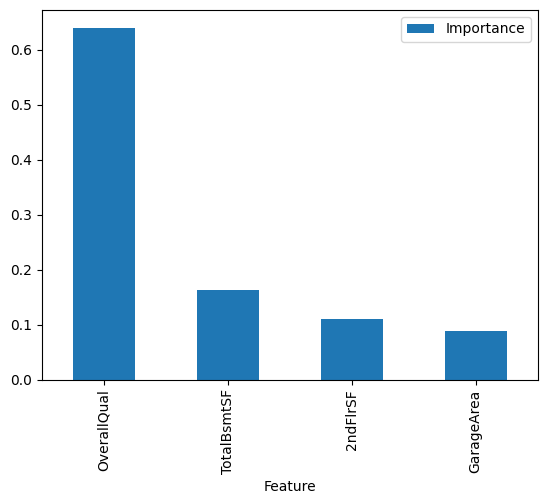

In [73]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_rgr['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross-check with metrics defined in the ML business case.
* 80% Recall for Churn, on train and test set.
* 80% Precision for no Churn on train and test set. 

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(X, y, pipeline):
    prediction = pipeline.predict(X)

    print('---  Regression Metrics  ---')
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y, prediction)}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y, prediction)}")
    print(f"Root Mean Squared Error (RMSE): {mean_squared_error(y, prediction, squared=False)}")
    print(f"R-squared (R^2): {r2_score(y, prediction)}")

def reg_performance(X_train, y_train, X_test, y_test, pipeline):
    print("#### Train Set #### \n")
    regression_metrics(X_train, y_train, pipeline)

    print("\n#### Test Set ####\n")
    regression_metrics(X_test, y_test, pipeline)

In [75]:
reg_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_rgr)

# The function reg_performance prints out the regression metrics 
# for our training and test datasets using the pipeline we trained.

#### Train Set #### 

---  Regression Metrics  ---
Mean Absolute Error (MAE): 17783.586852843655
Mean Squared Error (MSE): 580749250.1311158
Root Mean Squared Error (RMSE): 24098.739596317395
R-squared (R^2): 0.905675977685939

#### Test Set ####

---  Regression Metrics  ---
Mean Absolute Error (MAE): 22559.90207960311
Mean Squared Error (MSE): 1174203230.4839911
Root Mean Squared Error (RMSE): 34266.64895323135
R-squared (R^2): 0.8299697739446306


The results show only marginal differences for the test set, in comparison to previous model fitted on all features.

# Step 4: push files to repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [46]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_housing/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

In [47]:
print(X_train.shape)
X_train.head()

(1168, 4)


,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
618,9,495.850351,0,285.045723
870,5,280.785318,0,133.391173
92,5,276.257124,0,176.329005
817,8,439.843394,0,309.970775
302,7,433.785653,0,305.798023


In [48]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [49]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [50]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [51]:
print(X_test.shape)
X_test.head()

(292, 4)


,OverallQual,TotalBsmtSF,2ndFlrSF,GarageArea
529,6,541.596143,0,193.645231
491,6,258.462952,620,108.556198
459,5,233.273633,224,148.929238
279,7,345.753788,866,200.542297
655,6,183.422323,0,117.449491


In [52]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [53]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [54]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_rgr, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.

In [76]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('ConvertToInt64', ConvertToInt64(columns=['2ndFlrSF'])),
                ('MedianImputer', MeanMedianImputer(variables=['2ndFlrSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF',
                                                  'GarageArea']))])

In [77]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/rgr_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_housing/v1/rgr_pipeline_data_cleaning_feat_eng.pkl']

* Pipeline responsible for Feature Scaling, and Model

In [57]:
pipeline_rgr

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GradientBoostingRegressor(random_state=0))])

In [58]:
joblib.dump(value=pipeline_rgr ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_housing/v1/clf_pipeline_model.pkl']

## Feature Importance plot

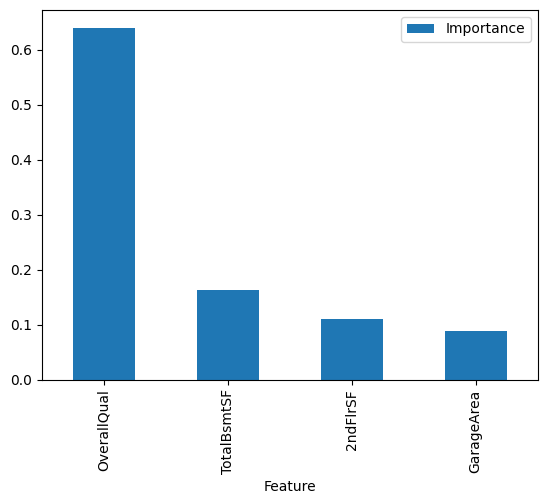

In [59]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

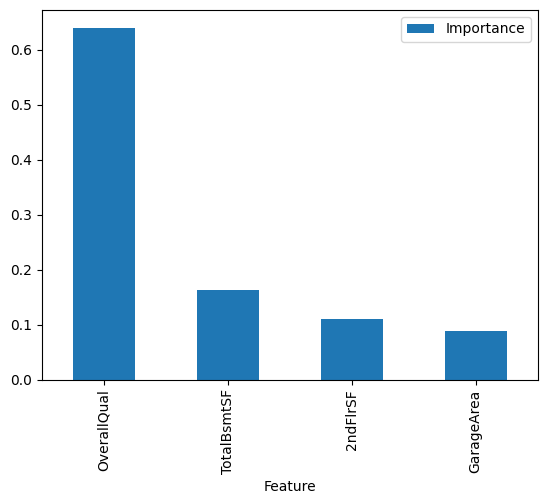

In [60]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job, you should clear outputs, then run git commands to push files to the repo. Next, move on to Predict Tenure notebook

---